# Actividad grupal: Evaluación de la segmentación 

| **Asignatura**           | **Integrantes:**               | **Fecha**|
|--------------------------|--------------------------------|----------|
| Percepción Computacional | Avila Ramírez Larissa Samantha |          |
|                          | Avendaño Nahum                 | 27/05/25 |
|                          | Hernández Román                |          |


## Ground Truth

La **ground truth** es la referencia objetiva y verificada con la que se comparan las predicciones de un sistema para saber qué tan bien está funcionando.

Para validar la segmentación, tiene que haber una segmentación de referencia, lo que se denomina generalmente como un **ground truth**. Este ground truth se tiene que obtener de forma manual, pintando la silueta de los objetos de interés con un color uniforme.

A menudo, la obtención de estos ground truths se denomina _etiquetado manual de imágenes_ o, en este caso, _segmentación manual de imágenes_

En el aprendizaje automático y el análisis de datos, la ground truth actúa como una brújula que orienta los modelos hacia la fiabilidad, la precisión y la exhaustividad. Sin la ground truth, los modelos de IA pueden descarriarse y dar lugar a aplicaciones defectuosas y decisiones inadecuadas o sesgadas.

La ground truth no es estática; evoluciona con el tiempo, reflejando patrones y verdades cambiantes. Su naturaleza dinámica subraya su importancia, impulsando a los científicos e ingenieros de datos a refinar y validar continuamente sus datos de formación para que coincidan con las verdades actuales.

### ¿Por qué es Importante?

**Evaluación**: Se usa para comparar las predicciones del modelo con la verdad conocida y así medir precisión, recall, F1-score, etc.

**Entrenamiento supervisado**: El modelo aprende ajustando sus parámetros para que sus salidas coincidan lo más posible con el ground truth.

**Análisis de errores**: Ayuda a entender en qué casos el modelo falla o acierta.


> En detección de objetos, la **ground truth** son las anotaciones correctas (hechas por humanos) sobre qué objetos hay en la imagen y dónde están. Se usa para entrenar, validar y evaluar el rendimiento de los modelos.


## Split & Merge

### Definición

Es uno de los procesos para dividir una imagen en regiones o segmentos que tienen características similares. 

Divide la imagen en regiones más pequeñas y luego las fusiona si cumplen ciertos criterios de similitud.

### Ejemplo

#### Se definen los parámetros iniciales a utilizar

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

THRESHOLD = 300  # umbral de varianza para dividir
MIN_SIZE = 16    # tamaño mínimo de región 
IMAGE_TEST = 'assets/salmon.jpg'

#### Se evalúa si la región es Homogénea (_tomando en cuenta que la varianza de intensidad de los píxeles es baja, y en caso de no serlo, se divide en 4 subregiones_)

In [33]:
def is_homogeneous(region):
    return np.var(region) < THRESHOLD

#### División Recursiva (SPLIT)

En donde:
- **y** -> selecciona las filas de y hasta **y+h**
- **x** -> selecciona las columnas de x hasta **x+w**
- **img[y,h]** -> es el recorte de la region de la imagen

In [34]:
def split(img, x, y, w, h):
    region = img[y:y+h, x:x+w]

    if w <= MIN_SIZE or h <= MIN_SIZE or is_homogeneous(region):
        return [(x, y, w, h)]
    
    w2, h2 = w // 2, h // 2
    regions = []
    regions += split(img, x, y, w2, h2)
    regions += split(img, x + w2, y, w2, h2)
    regions += split(img, x, y + h2, w2, h2)
    regions += split(img, x + w2, y + h2, w2, h2)
    return regions

#### Merge por cercanía y valor medio

In [35]:
def merge(img, regions):
    canvas = np.zeros_like(img)
    for x, y, w, h in regions:
        region = img[y:y+h, x:x+w]
        mean_val = int(np.mean(region))
        canvas[y:y+h, x:x+w] = mean_val
    return canvas

#### Carga de image en escala de grises

In [36]:
regions = split(image, 0, 0, w, h)
segmented = merge(image, regions)

#### Aplicación de Split & Merge

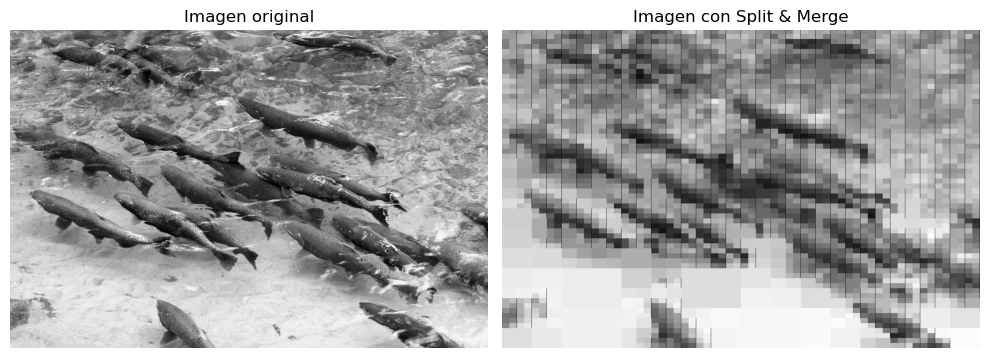

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Imagen con Split & Merge")
plt.imshow(segmented, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()